In [ ]:
# Build a Conversational RAG Retrieval QA Chain with proper citations, like [1][2] with article title, pages and context
# (RAG_QA_Cita-3.ipynb) is the best version App, with conversational RAG and good citation style. The others RAG App created before can be ignored.

# Multi-Vector Retriever for RAG on Tables, text, and images 
# from Artikel_3 (https://blog.langchain.dev/semi-structured-multi-modal-rag/)
# Cookbook for multi-modal (text + tables + images) RAG (https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
# Artikel_4 (https://python.langchain.com/docs/how_to/multimodal_inputs/)

In [2]:
# Read Resource 1. <How to get your RAG application to return sources?> (https://python.langchain.com/docs/how_to/qa_sources/)

# 1. use LangSmith
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [3]:
# Configure environment to connect to LangSmith.
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"]="KI_multi-modal-RAG"

In [16]:
# 2. Components
# 2.1 Select chat model: Google Gemini

import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")


In [5]:
# 2.2 Select embedding model: HuggingFace
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [6]:
# 2.3 Select vector store: Chroma (install and upgrade langchain_chroma)
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [ ]:
# 3. index our documents:

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 3.1 Load PDF files from a folder
import os
folder_path = "D:/4-IntoCode/16_LangChain/AgilProjekt_multiModel/AKAP1/"  # company folder, use / instead of \
all_docs = []

for file in os.listdir(folder_path):
    if file.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(folder_path, file))
        pages = loader.load_and_split()
        all_docs.extend(pages)

# 3.2 Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = splitter.split_documents(all_docs)
print(f"Loaded {len(docs)} chunks from {len(all_docs)} pages across {len(os.listdir(folder_path))} PDF files.")
# Result: "Loaded 96 chunks from 26 pages across 1 PDF files."


Loaded 96 chunks from 26 pages across 1 PDF files.


In [8]:
# 3.3 Index chunks
_ = vector_store.add_documents(documents=docs)

In [ ]:
# 4. RAG application: reconstruct the Q&A app with sources
# Conversational RAG: additional tool-calling features of chat models, a "back-and-forth" conversational user experience.
# Read Resource 2. <How to get a RAG application to add citations?> (https://python.langchain.com/docs/how_to/qa_citations/)
# get a model to cite which parts of the source documents it referenced in generating its response.
# Method: Using tool-calling to cite document IDs;


    

In [11]:
# build and compile the exact same application with 2 changes:
# 1. add a context key of the state to store retrieved documents;
# 2. In the generate step, we pluck out the retrieved documents and populate them in the state.
from langchain_core.messages import SystemMessage
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from typing import List
from langchain_core.documents import Document

# Define state for application (modified)
class State(MessagesState):
    context: List[Document] # change 1



# load a retriever and construct our prompt:
# In the article 2, the author uses WikipediaRetriever, 
# Combine_Step_1: use our own MultiVectorRetriever from (Multi_Modal_RAG-v2.ipynb)
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore

store = InMemoryStore()
retriever = MultiVectorRetriever(
    vectorstore=vector_store,
    docstore=store,
    id_key="doc_id",  # Keep track of original full content
)
retriever.search_kwargs["k"] = 4  # number of documents to retrieve

# 4.1 Define the tool
from langchain_core.tools import tool

# Combine_Step_3: Update the Tool to Use Multi-Vector Retrieval and Store Metadata
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = retriever.invoke(query) # change 3

    # Rebuild full documents from store using doc_id, change 4
    full_docs = []
    for doc in retrieved_docs:
        doc_id = doc.metadata["doc_id"]
        full_text = retriever.docstore.mget([doc_id])[0]
        full_docs.append(Document(page_content=full_text, metadata=doc.metadata))
    
    serialized = "\n\n".join(
        f"Source: {doc.metadata}\nContent: {doc.page_content}"
        for doc in full_docs
    )
    return serialized, full_docs

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: State):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

# Combine_Step_2: Summarize Text + Tables and Load into MultiVectorRetriever
# Use your partition_pdf + summary chain:
from unstructured.partition.pdf import partition_pdf
from typing import Any
from pydantic import BaseModel

# Use unstructured to extract
raw_pdf_elements = partition_pdf(
    filename=folder_path + file,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
)

class Element(BaseModel):
    type: str
    text: Any

# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Separate into text and table
text_elements = [e for e in categorized_elements if e.type == "text"]
table_elements = [e for e in categorized_elements if e.type == "table"]

# Multi-vector retriever
# Text and Table summaries
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise and essential summary of the table or text. 
Each summary should not longer than 10 sentences. Please keep it as short as possible. \
Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ") # use Google Gemini instead of OpenAI

from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemma-3-27b-it", temperature=0)    # use "gemma-3-27b-it" instead of gemini-2.0-flash or 1.5

summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# Summarize each
text_summaries = summarize_chain.batch([e.text for e in text_elements][:10], {"max_concurrency": 1})
table_summaries = summarize_chain.batch([e.text for e in table_elements], {"max_concurrency": 1})

# Add to retriever
from langchain_core.documents import Document
import uuid

# Store original full text in memory, summaries in vectorstore
# Before adding summaries to the vectorstore, Add Document Title & Page Metadata
text_ids = [str(uuid.uuid4()) for _ in text_elements]
retriever.vectorstore.add_documents([
    Document(
    page_content=summary,
    metadata={
        "doc_id": doc_id,
        "source": file,  # extract from PDF path
        "page": getattr(element.metadata, "page_number", -1)
    }
)

    for summary, doc_id in zip(text_summaries, text_ids)
])
retriever.docstore.mset(list(zip(text_ids, [e.text for e in text_elements])))

# Same for tables
table_ids = [str(uuid.uuid4()) for _ in table_elements]
retriever.vectorstore.add_documents([
    Document(
    page_content=summary,
    metadata={
        "doc_id": doc_id,
        "source": file,  # extract from PDF path
        "page": getattr(element.metadata, "page_number", -1)
    }
)
    for summary, doc_id in zip(table_summaries, table_ids)
])
retriever.docstore.mset(list(zip(table_ids, [e.text for e in table_elements])))


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt (customize the prompt)
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        """You are an assistant for question-answering tasks. 
        ONLY Use the following pieces of retrieved context to answer the question. 
        For each fact, cite its source number like [1][2]. 
        At the end of your answer, add a list of sources in the format of [1] <source title>, page <page number> and so on.
        If you don't know the answer, If unsure, say 'I don't know'."""
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Process and format the answer 
    result = llm.invoke(prompt)

    # Get the content of the AI message
    answer = result.content.strip()

    # Try to get any custom metadata or sources (if your LLM provides it through a custom return)
    sources = result.additional_kwargs.get("source_documents", [])
    
    # Add formatted citations (with prefered cictation style)
    if sources:
        answer += "\n\nSources:"
        for i, doc in enumerate(sources, start=1):
            source_info = doc.metadata.get('source', 'Unknown document')
            page_info = f", page {doc.metadata['page']}" if 'page' in doc.metadata else ""
            answer += f"\n[{i}] {source_info}{page_info}"
    
    print("Answer:\n", answer)
    
    # Run
    context = []
    for tool_message in tool_messages:                  # change 2
        context.extend(tool_message.artifact)
    return {"messages": [result], "context": context}

In [12]:
# compile the application:
from langgraph.graph import StateGraph
from langgraph.graph import END
from langgraph.prebuilt import tools_condition


graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

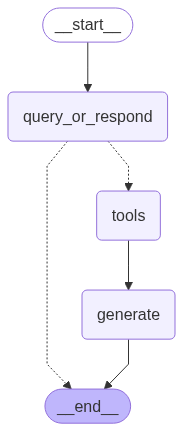

In [13]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Invoking our application, the retrieved Document objects are accessible from the application state.
# # about Text
input_message = "What is AKAP1?" # the answer should be with ToolMessage

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is AKAP1?
================================== Ai Message ==================================
Tool Calls:
  retrieve (af68762f-c1ed-4a26-ac2c-0ab236004f86)
 Call ID: af68762f-c1ed-4a26-ac2c-0ab236004f86
  Args:
    query: AKAP1
================================= Tool Message =================================
Name: retrieve


Answer:
 AKAP1 is a protein that targets protein kinase A (PKA) to the mitochondria [1].
 
 It is a mitochondrial protein and is involved in cAMP signaling [1]. AKAP1 can regulate mitochondrial function by modulating mitochondrial structure and respiration [1].
 
 AKAP1 can be used as a therapeutic target for various diseases, including cancer, heart disease, and diabetes [1].
================================== Ai Message ==================================

AKAP1 is a protein that targets protein kinase A (PKA) to the mitochondria [1].
 
 It is a mitochondrial protein and is involved

In [30]:
# Question 2: about Table
input_message = "tell me wabout AKAP variants?" # the answer should be with ToolMessage

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

tell me wabout AKAP variants?
================================== Ai Message ==================================
Tool Calls:
  retrieve (6c869469-10a4-4bc6-bfa0-e5c5c5ea4058)
 Call ID: 6c869469-10a4-4bc6-bfa0-e5c5c5ea4058
  Args:
    query: AKAP variants
================================= Tool Message =================================
Name: retrieve

Error: AttributeError("'str' object has no attribute 'metadata'")
 Please fix your mistakes.
Answer:
 I am unable to provide information about AKAP variants, as the provided context does not contain any details on this topic.


TypeError: 'NoneType' object is not iterable